# CartPole Using Q-Learning

[CartPole Documentation](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py)

### Action Space

The action is a `ndarray` with shape `(1,)` which can take values `{0, 1}` indicating the direction of the fixed force the cart is pushed with.

| Num | Action                 |
|-----|------------------------|
| 0   | Push cart to the left  |
| 1   | Push cart to the right |

**Note**: The velocity that is reduced or increased by the applied force is not fixed and it depends on the angle the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it

### Observation Space

The observation is a `ndarray` with shape `(4,)` with the values corresponding to the following positions and velocities:

| Num | Observation           | Min                 | Max               |
|-----|-----------------------|---------------------|-------------------|
| 0   | Cart Position         | -4.8                | 4.8               |
| 1   | Cart Velocity         | -Inf                | Inf               |
| 2   | Pole Angle            | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |
| 3   | Pole Angular Velocity | -Inf                | Inf               |

**Note:** While the ranges above denote the possible values for observation space of each element, it is not reflective of the allowed values of the state space in an unterminated episode. Particularly:

- The cart x-position (index 0) can be take values between `(-4.8, 4.8)`, but the episode terminates if the cart leaves the `(-2.4, 2.4)` range.
- The pole angle can be observed between  `(-.418, .418)` radians (or **±24°**), but the episode terminates if the pole angle is not in the range `(-.2095, .2095)` (or **±12°**)


## Q-Learning Table

| Num | Start | Step Width | Steps (Inc. 0) |
|-----|-------|------------|----------------|
| 0   | -2.4  | 0.1        | 48 + 1         |
| 1   | -4    | 0.01       | 800 + 1        |
| 2   | -12   | 1°         | 24 + 1         |
| 3   | -4    | 0.01       | 800 + 1        |


In [56]:
import gym
import math
import numpy as np
import matplotlib.pyplot as plt

## Testing with all 4 observations spaces

- Not actually necessary
- Truly only need a q-table for all the angles the pole can be at

In [57]:
""" Searching for ranges of observation space """

"""
env = gym.make("CartPole-v1")

min_vals = [0, 0, 0, 0]
max_vals = [0, 0, 0, 0]

episodes = 100000
for i_ep in range(episodes):
    # print("Episode:", i_ep + 1)

    obs = env.reset()
    done = False

    while not done:
        # env.render()

        action = env.action_space.sample()

        obs, reward, done, _ = env.step(action)
        
        if done: 
            break
        
        for i in range(len(obs)):
            min_vals[i] = min(obs[i], min_vals[i])
            max_vals[i] = max(obs[i], max_vals[i])

print("Min:", min_vals)
print("Max:", max_vals)
"""

'\nenv = gym.make("CartPole-v1")\n\nmin_vals = [0, 0, 0, 0]\nmax_vals = [0, 0, 0, 0]\n\nepisodes = 100000\nfor i_ep in range(episodes):\n    # print("Episode:", i_ep + 1)\n\n    obs = env.reset()\n    done = False\n\n    while not done:\n        # env.render()\n\n        action = env.action_space.sample()\n\n        obs, reward, done, _ = env.step(action)\n        \n        if done: \n            break\n        \n        for i in range(len(obs)):\n            min_vals[i] = min(obs[i], min_vals[i])\n            max_vals[i] = max(obs[i], max_vals[i])\n\nprint("Min:", min_vals)\nprint("Max:", max_vals)\n'

In [58]:
"""
q_table_params = {
    "start": [-2.4, -4, -12, -4],
    "step": [1, 2, 0, 2], # In digits after the decimal point
    "steps": [49, 801, 25, 801],
}

q_table = np.array(
    [np.zeros((steps_val,)) for steps_val in q_table_params["steps"]], dtype="object"
)
"""

'\nq_table_params = {\n    "start": [-2.4, -4, -12, -4],\n    "step": [1, 2, 0, 2], # In digits after the decimal point\n    "steps": [49, 801, 25, 801],\n}\n\nq_table = np.array(\n    [np.zeros((steps_val,)) for steps_val in q_table_params["steps"]], dtype="object"\n)\n'

In [59]:
""" Check to make sure that all continuous observations have translated to discrete spaces """

"""
env = gym.make("CartPole-v1")

episodes = 10000
for i_ep in range(episodes):
    obs = env.reset()
    done = False

    while not done:
        action = env.action_space.sample()

        obs, reward, done, _ = env.step(action)
        
        if done:
            break # Skips adding last observation to q-table

        for i in range(len(obs)):
            step = q_table_params["step"][i]
            
            power = 10 ** step
            
            if i == 2:
                val = math.degrees(obs[i])
            else:
                val = obs[i]
            
            index = int(round(val, step) * power)
            q_table[i][index] += 1

print(q_table[0])
"""

'\nenv = gym.make("CartPole-v1")\n\nepisodes = 10000\nfor i_ep in range(episodes):\n    obs = env.reset()\n    done = False\n\n    while not done:\n        action = env.action_space.sample()\n\n        obs, reward, done, _ = env.step(action)\n        \n        if done:\n            break # Skips adding last observation to q-table\n\n        for i in range(len(obs)):\n            step = q_table_params["step"][i]\n            \n            power = 10 ** step\n            \n            if i == 2:\n                val = math.degrees(obs[i])\n            else:\n                val = obs[i]\n            \n            index = int(round(val, step) * power)\n            q_table[i][index] += 1\n\nprint(q_table[0])\n'

## Q-Learning Agent Implementation

In [60]:
ALPHA = (
    0.5  # Learning rate -> how fast the values are propagated throughout the q-table
)
GAMMA = 0.9  # Discount factor -> how much the rewards are discounted from future steps
EPSILON = 0.1  # Greedy function -> exploration vs exploitation -> chance for the agent to make an educated guess

REWARD_SHAPING = -1000

EPISODE_LEN = 200
ENV_NAME = "CartPole-v1"


[Generating Docstrings](https://queirozf.com/entries/python-docstrings-reference-examples#:~:text=Python%20Docstrings%3A%20Reference%20%26%20Examples%201%20ReStructuredText%20%28reST%29,description%20of%20function.%20...%204%20Doctest%20Permalink.%20)

In [61]:
def discrete(observation):
    radians = observation[2]
    degrees = math.degrees(radians)
    rounded_degress = round(degrees)

    """Simplified architecture"""

    if rounded_degress < 0:
        return -1
    if rounded_degress > 0:
        return 1
    return 0

    """Per degree architecture"""

    return round(degrees)


def greedy():
    return np.random.rand() > EPSILON


def q_func(reward, q_current_value, q_forward_value):
    """Returns q_value to update q_table with"""

    q_value = ALPHA * (reward + GAMMA * q_forward_value - q_current_value)
    return q_value


def train(agent, episodes, render=False):
    scores = []

    for i in range(episodes):
        score = agent.evaluate(render)
        print("Episode:", i + 1, "\tScore:", score)

        scores.append(score)

    return scores


def graph(values):
    plt.plot(values)

    plt.title("Training Data")
    plt.xlabel("Episodes")
    plt.ylabel("Score")

    plt.show()


In [62]:
class QAgent:
    def __init__(self):
        self.q_table = np.zeros((3, 2))  # Simplified architecture
        # self.q_table = np.zeros((29, 2)) # Per degree architecture

        self.env = None
        self.make()

    def _forward(self, state, overrideGreedy=False):
        env = self.env
        q_table = self.q_table

        if not greedy() and not overrideGreedy:
            return env.action_space.sample()

        return np.argmax(q_table[state])

    def evaluate(self, render=False):
        """Evaluate Q-Learning Agent

        :param int cur_obs: Current observation state
        :param int for_obs: Forward observation state
        :param int cur_action: Current action state
        :param int for_action: Forward action state
        :param int rew: Forward observation reward
        :param float q_cur_val: Q-value of current state, current action -> Q(s, a)
        :param float q_for_val: Q-value of forward state, forward action -> Q(s', a')
        """

        env = self.env
        q_table = self.q_table

        cur_obs = discrete(env.reset())
        cur_action = self._forward(cur_obs)

        done = False
        score = 0
        step = 0

        while not done:
            if step == EPISODE_LEN:
                break

            if render:
                env.render()

            for_action = self._forward(cur_obs)

            for_obs, rew, done, _ = env.step(for_action)

            for_obs = discrete(for_obs)

            if done:
                pass
                rew = REWARD_SHAPING

            q_cur_val = q_table[cur_obs][cur_action]
            q_for_val = q_table[for_obs][self._forward(cur_obs, overrideGreedy=True)]
            q_value = q_func(rew, q_cur_val, q_for_val)
            q_table[cur_obs][cur_action] = q_value

            cur_obs = for_obs
            cur_action = for_action
            score += rew
            step += 1

        return score

    def make(self):
        if self.env is None:
            env = gym.make(ENV_NAME)
            env._max_episode_steps = EPISODE_LEN
            self.env = env

    def close(self):
        if self.env is not None:
            self.env.close()
            self.env = None


In [63]:
a = QAgent()

Episode: 1 	Score: -992.0
Episode: 2 	Score: -977.0
Episode: 3 	Score: -988.0
Episode: 4 	Score: -987.0
Episode: 5 	Score: -978.0
Episode: 6 	Score: -992.0
Episode: 7 	Score: -989.0
Episode: 8 	Score: -977.0
Episode: 9 	Score: -992.0
Episode: 10 	Score: -985.0
Episode: 11 	Score: -992.0
Episode: 12 	Score: -991.0
Episode: 13 	Score: -967.0
Episode: 14 	Score: -969.0
Episode: 15 	Score: -992.0
Episode: 16 	Score: -992.0
Episode: 17 	Score: -983.0
Episode: 18 	Score: -992.0
Episode: 19 	Score: -992.0
Episode: 20 	Score: -993.0
Episode: 21 	Score: -993.0
Episode: 22 	Score: -993.0
Episode: 23 	Score: -972.0
Episode: 24 	Score: -992.0
Episode: 25 	Score: -976.0
Episode: 26 	Score: -986.0
Episode: 27 	Score: -980.0
Episode: 28 	Score: -989.0
Episode: 29 	Score: -990.0
Episode: 30 	Score: -958.0
Episode: 31 	Score: -992.0
Episode: 32 	Score: -986.0
Episode: 33 	Score: -992.0
Episode: 34 	Score: -991.0
Episode: 35 	Score: -978.0
Episode: 36 	Score: -958.0
Episode: 37 	Score: -980.0
Episode: 3

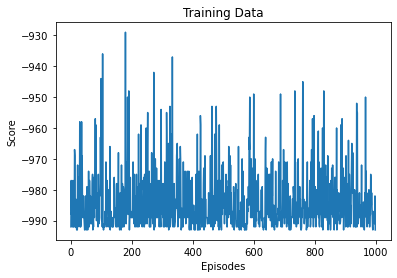

In [64]:
scores = train(a, 1000)
graph(scores)

In [65]:
print(a.q_table)

[[  95.48058421   95.13534585]
 [-499.08141364    2.3608986 ]
 [ -75.17966781 -500.02380951]]


In [93]:
a.evaluate(render=True)

-992.0

## Non-convergence Problem
- Q-Agent is not complex enough
- Requires knowledge of other observations such as angular velocity
- Would create more dimensions to the q_table
  - 3D array for one more parameter
  - 4D array for two more parameters
  - etc...